In [74]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('notebook')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [75]:
ee_dense = pd.read_csv('densenet_all_inference_test.csv', index_col=0)
co_dense = pd.read_csv('dense_conv_inference_test.csv', index_col=0)
ee_dense.loc[ee_dense['threshold']==0.9].time.mean()

0.04220325983999915

In [76]:
ee_dense = ee_dense.to_numpy()

In [77]:
ee_dense = pd.DataFrame(ee_dense[1:], columns=['threshold', 'exit', 'prediction', 'target', 'correct', 'score', 'time'])

In [78]:
ee_dense.mean()

threshold      0.500009
exit           0.953377
prediction    48.892442
target        49.501100
correct        0.800329
score          0.785513
time           0.032120
dtype: float64

In [79]:
len(ee_dense.loc[ee_dense['exit']==0])

17020

In [80]:
len(ee_dense.loc[(ee_dense['exit']==0) & (ee_dense['correct'] == False)])

3488

In [81]:
len(ee_dense.loc[ee_dense['exit']==1])

17154

In [82]:
len(ee_dense.loc[ee_dense['exit']==2])

6728

In [83]:
len(ee_dense.loc[ee_dense['exit']==3])

4097

In [84]:
len(ee_dense.loc[(ee_dense['exit']==3) & (ee_dense['correct'] == False)])

1759

In [85]:
len(ee_dense.loc[(ee_dense['correct'] == False)])

8985

In [86]:
arr = []

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in ee_dense.groupby(['threshold']):
    tmp = i[1].mean()
    arr.append((tmp.correct, tmp.time))

#sns.lineplot(data=i[1].mean().correct)
ee_dense_stats = pd.DataFrame(arr, columns=["Mean Accuracy", "Mean Time"], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ee_dense_stats

,Mean Accuracy,Mean Time
0.1,0.656531,0.021872
0.2,0.724800,0.025096
0.3,0.766200,0.027767
0.4,0.796200,0.030118
0.5,0.823600,0.032195
0.6,0.841000,0.034569
0.7,0.854000,0.036443
0.8,0.866200,0.038817
0.9,0.874400,0.042203


In [87]:
co_dense.time.mean()

0.059422162539999705

# ResNet

In [88]:
ee_res = pd.read_csv('resnet101_all_inference_test.csv', index_col=0)
co_res = pd.read_csv('resnet_conv_inference_test.csv', index_col=0)
ee_res.correct = ee_res.correct.astype(int)
ee_res

,threshold,exit,prediction,target,correct,score_margin,time
0,0.1,0,0,0,1,0.204359,0.977127
1,0.1,0,0,0,1,0.989505,0.014066
2,0.1,0,0,0,1,0.357393,0.014050
3,0.1,0,0,0,1,0.870633,0.012749
4,0.1,0,0,0,1,0.660327,0.013005
...,...,...,...,...,...,...,...
44995,0.9,2,99,99,1,0.999986,0.047860
44996,0.9,2,99,99,1,0.934735,0.043598
44997,0.9,2,99,99,1,0.999788,0.044869
44998,0.9,2,99,99,1,1.000000,0.044711


In [89]:
co_res.mean().time

0.04474636967999995

In [90]:
ee_res = ee_res.to_numpy()

In [91]:
ee_res = pd.DataFrame(ee_res[1:], columns=['threshold', 'exit', 'prediction', 'target', 'correct', 'score', 'time'])

In [92]:
arr = []

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in ee_res.groupby(['threshold']):
    tmp = i[1].mean()
    tmp2 = i[1].std()
    arr.append((tmp.correct, tmp.time, tmp2.correct, tmp2.time))
    

#sns.lineplot(data=i[1].mean().correct)
ee_res_stats = pd.DataFrame(arr, columns=["Mean Accuracy", "Mean Time", "Std. Accuracy", "Std. Time"], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ee_res_stats

,Mean Accuracy,Mean Time,Std. Accuracy,Std. Time
0.1,0.645729,0.017184,0.478340,0.009242
0.2,0.735200,0.021034,0.441271,0.012512
0.3,0.788400,0.023683,0.408484,0.013815
0.4,0.822600,0.026222,0.382045,0.014730
0.5,0.848800,0.028200,0.358280,0.015086
0.6,0.866200,0.029933,0.340471,0.015105
0.7,0.875400,0.032040,0.330298,0.015258
0.8,0.884200,0.033742,0.320017,0.014821
0.9,0.890200,0.036733,0.312672,0.014237


# MSDNet

In [102]:
ee_msd= pd.read_csv('msdnet_inference_test.csv', index_col=0)
ee_msd.correct = ee_msd.correct.astype(int)
ee_msd

,threshold,exit,prediction,target,correct,score_margin,time
0,0.1,0,0,0,1,0.952709,1.013905
1,0.1,0,0,0,1,0.999861,0.036922
2,0.1,0,0,0,1,0.988251,0.037888
3,0.1,0,0,0,1,0.999969,0.036743
4,0.1,0,0,0,1,0.999953,0.037214
...,...,...,...,...,...,...,...
44995,0.9,2,99,99,1,0.966731,0.094420
44996,0.9,3,99,99,1,0.071395,0.097776
44997,0.9,2,99,99,1,0.998703,0.076617
44998,0.9,1,99,99,1,0.999998,0.060746


In [103]:
ee_msd.mean().time

0.0449296651800002

In [104]:
ee_msd = ee_msd.to_numpy()

In [105]:
ee_msd = pd.DataFrame(ee_msd[1:], columns=['threshold', 'exit', 'prediction', 'target', 'correct', 'score', 'time'])

In [106]:
arr = []

x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in ee_msd.groupby(['threshold']):
    tmp = i[1].mean()
    tmp2 = i[1].std()
    arr.append((tmp.correct, tmp.time, tmp2.correct, tmp2.time))
    

#sns.lineplot(data=i[1].mean().correct)
ee_msd_stats = pd.DataFrame(arr, columns=["Mean Accuracy", "Mean Time", "Std. Accuracy", "Std. Time"], index=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ee_msd_stats

,Mean Accuracy,Mean Time,Std. Accuracy,Std. Time
0.1,0.769354,0.039120,0.421288,0.005985
0.2,0.784800,0.040646,0.411002,0.008753
0.3,0.801000,0.041696,0.399288,0.010437
0.4,0.812400,0.043611,0.390431,0.013164
0.5,0.825200,0.044177,0.379834,0.013148
0.6,0.833800,0.045522,0.372297,0.014635
0.7,0.843000,0.047342,0.363837,0.016076
0.8,0.851600,0.049499,0.355532,0.017836
0.9,0.862600,0.052559,0.344304,0.019560


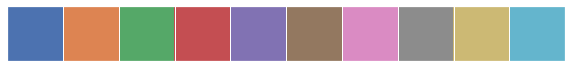

In [107]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

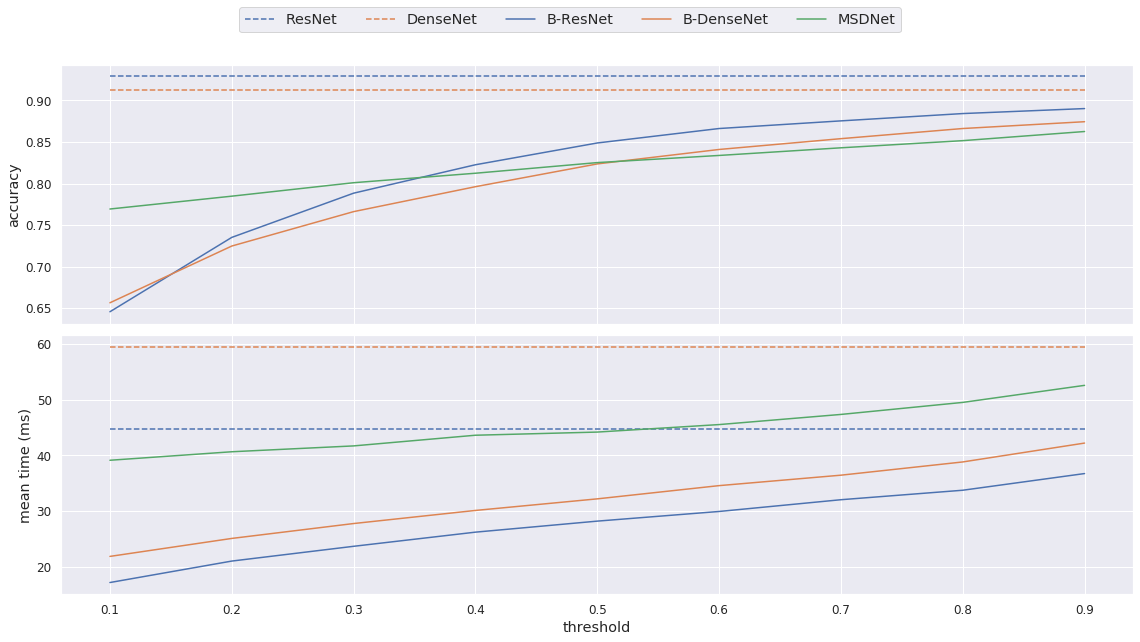

In [108]:
fig, axes = plt.subplots(2,1, sharex=True)
sns.lineplot(x=x, y=co_res.mean().correct*np.ones(9), ax=axes[0], color=current_palette[0])
sns.lineplot(x=x, y=co_res.mean().time*np.ones(9)*1000, ax=axes[1], color=current_palette[0])

sns.lineplot(x=x, y=co_dense.mean().correct*np.ones(9), ax=axes[0],  color=current_palette[1])
sns.lineplot(x=x, y=co_dense.mean().time*np.ones(9)*1000, ax=axes[1],  color=current_palette[1])

sns.lineplot(data=ee_res_stats['Mean Accuracy'], ax=axes[0], color=current_palette[0])
sns.lineplot(data=ee_res_stats['Mean Time']*1000, ax=axes[1], color=current_palette[0])

sns.lineplot(data=ee_dense_stats['Mean Accuracy'], ax=axes[0], color=current_palette[1])
sns.lineplot(data=ee_dense_stats['Mean Time']*1000, ax=axes[1],  color=current_palette[1])

sns.lineplot(data=ee_msd_stats['Mean Accuracy'], ax=axes[0], color=current_palette[2])
sns.lineplot(data=ee_msd_stats['Mean Time']*1000, ax=axes[1],  color=current_palette[2])

axes[0].set_ylabel('accuracy')
axes[1].set_ylabel('mean time (ms)')
plt.xlabel('threshold')



axes[0].lines[0].set_linestyle("--")

axes[1].lines[0].set_linestyle("--")

axes[0].lines[1].set_linestyle("--")

axes[1].lines[1].set_linestyle("--")


fig.legend([ 'ResNet', 'DenseNet', 'B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=5, loc="upper center")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('compare_exiting_vs_no_exiting.png', dpi=300)

In [58]:
len(ee_res.loc[ee_res['exit']==0])

13389

In [59]:
len(ee_res.loc[(ee_res['exit']==0) & (ee_res['correct'] == False)])

3062

In [60]:
len(ee_res.loc[ee_res['exit']==1])

14011

In [61]:
len(ee_res.loc[ee_res['exit']==2])

14136

In [62]:
len(ee_res.loc[ee_res['exit']==3])

3463

In [63]:
len(ee_res.loc[(ee_res['exit']==3) & (ee_res['correct'] == False)])

1736

In [64]:
len(ee_res.loc[(ee_res['correct'] == False)])

8216

In [65]:
ee_res.groupby(['threshold', 'exit']).size()

threshold  exit
0.1        0.0     3297
           1.0     1252
           2.0      424
           3.0       26
0.2        0.0     2456
           1.0     1584
           2.0      875
           3.0       85
0.3        0.0     1940
           1.0     1704
           2.0     1184
           3.0      172
0.4        0.0     1571
           1.0     1717
           2.0     1448
           3.0      264
0.5        0.0     1285
           1.0     1708
           2.0     1653
           3.0      354
0.6        0.0     1029
           1.0     1673
           2.0     1853
           3.0      445
0.7        0.0      828
           1.0     1582
           2.0     2039
           3.0      551
0.8        0.0      615
           1.0     1489
           2.0     2220
           3.0      676
0.9        0.0      368
           1.0     1302
           2.0     2440
           3.0      890
dtype: int64

In [66]:
merged = pd.DataFrame({'idx': ['ResNet', 'DenseNet'], 'dfs':[ee_res, ee_dense]})
merged

,idx,dfs
0,ResNet,threshold exit prediction target co...
1,DenseNet,threshold exit prediction target correct...


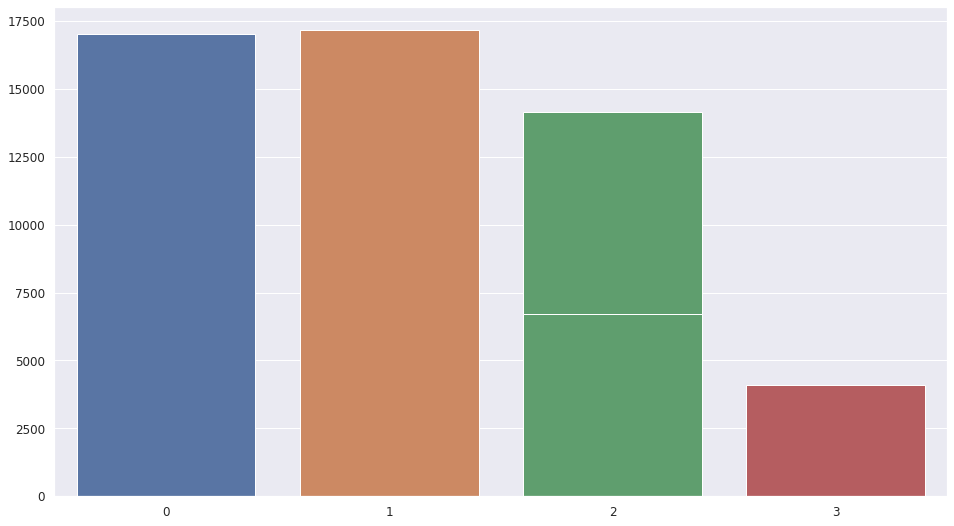

In [67]:
fig, axes = plt.subplots(1,1)
sns.barplot(x=np.arange(0,4,1), y=ee_res.groupby('exit').size(), ax=axes)
sns.barplot(x=np.arange(0,4,1), y=ee_dense.groupby('exit').size(), ax=axes)


In [112]:
 ee_msd.groupby(['threshold', 'exit']).size()

threshold  exit
0.1        0.0     4704
           1.0      255
           2.0       36
           3.0        4
0.2        0.0     4456
           1.0      427
           2.0       87
           3.0       30
0.3        0.0     4237
           1.0      572
           2.0      126
           3.0       65
0.4        0.0     4037
           1.0      669
           2.0      185
           3.0      109
0.5        0.0     3850
           1.0      756
           2.0      223
           3.0      171
0.6        0.0     3666
           1.0      809
           2.0      279
           3.0      246
0.7        0.0     3440
           1.0      862
           2.0      335
           3.0      363
0.8        0.0     3199
           1.0      891
           2.0      377
           3.0      533
0.9        0.0     2855
           1.0      934
           2.0      407
           3.0      804
dtype: int64

In [109]:
ee_res.exit= ee_res.exit.astype('int')
d = {    'ResNet': ee_res.groupby(['threshold', 'exit']).size(),
         'DenseNet': ee_dense.groupby(['threshold', 'exit']).size(),
         'MSDNet': ee_msd.groupby(['threshold', 'exit']).size()   }
df = pd.DataFrame(d)

df = df / 5000
df

ResNet  DenseNet  MSDNet
threshold exit                          
0.1       0     0.6594    0.7392  0.9408
          1     0.2504    0.2250  0.0510
          2     0.0848    0.0324  0.0072
          3     0.0052    0.0032  0.0008
0.2       0     0.4912    0.5888  0.8912
          1     0.3168    0.3262  0.0854
          2     0.1750    0.0716  0.0174
          3     0.0170    0.0134  0.0060
0.3       0     0.3880    0.4912  0.8474
          1     0.3408    0.3690  0.1144
          2     0.2368    0.1066  0.0252
          3     0.0344    0.0332  0.0130
0.4       0     0.3142    0.4130  0.8074
          1     0.3434    0.3950  0.1338
          2     0.2896    0.1380  0.0370
          3     0.0528    0.0540  0.0218
0.5       0     0.2570    0.3452  0.7700
          1     0.3416    0.4144  0.1512
          2     0.3306    0.1626  0.0446
          3     0.0708    0.0778  0.0342
0.6       0     0.2058    0.2836  0.7332
          1     0.3346    0.4298  0.1618
          2     0.3706    0.1798  0.0558
          3     0.0890    0.1068  0.0492
0.7       0     0.1656    0.2358  0.6880
          1     0.3164    0.4344  0.1724
          2     0.4078    0.1956  0.0670
          3     0.1102    0.1342  0.0726
0.8       0     0.1230    0.1842  0.6398
          1     0.2978    0.4294  0.1782
          2     0.4440    0.2148  0.0754
          3     0.1352    0.1716  0.1066
0.9       0     0.0736    0.1230  0.5710
          1     0.2604    0.4076  0.1868
          2     0.4880    0.2442  0.0814
          3     0.1780    0.2252  0.1608

Text(0, 0.5, '% of samples exited')

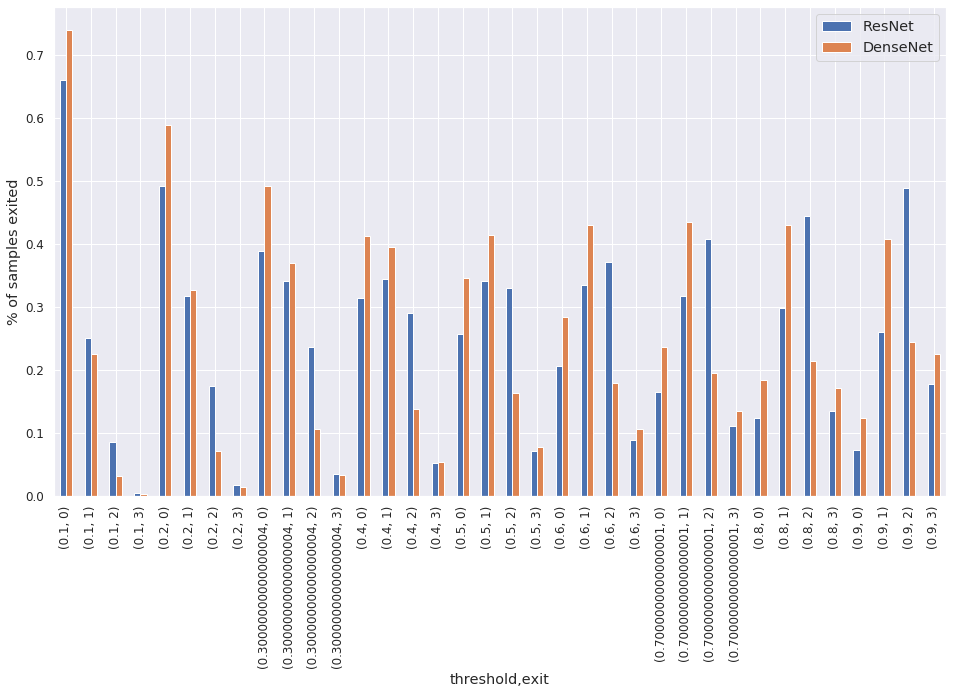

In [69]:
ax = df.plot(kind='bar')
ax.set_ylabel('% of samples exited')

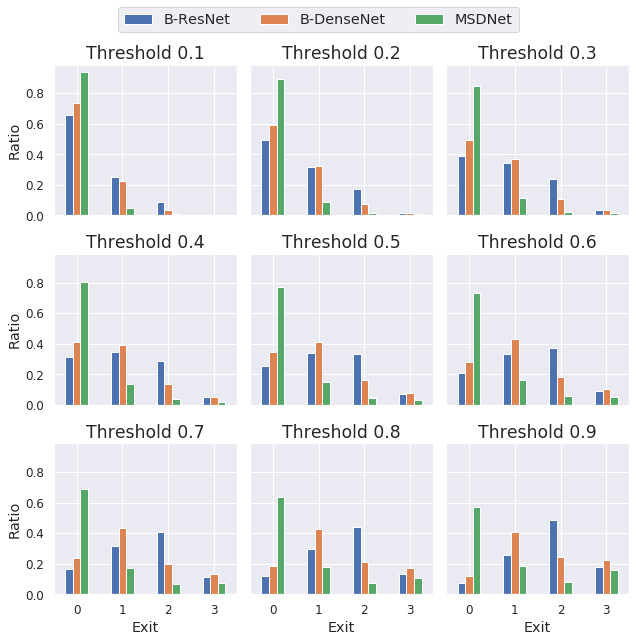

In [111]:
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(9,9))
for i, data in zip(axes.flat, df.groupby('threshold')):
    i.set_title('Threshold {:0.1f}'.format(data[0]))
    data[1].plot(kind='bar', ax=i, legend=False)
    i.label_outer()
    #i.xtickslabels([1, 2, 3, 4])
    i.set(xlabel='Exit', ylabel='Ratio', xticks=[0,1,2,3])
    i.set_xticklabels([0,1,2,3,4])
    
    for tick in i.get_xticklabels():
        tick.set_rotation(0)
    
fig.legend(['B-ResNet', 'B-DenseNet', 'MSDNet'], ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.savefig('inference_threshold_test.png', dpi=300)